# Customer churn

It is required to predict whether a customer will leave 'Beta-Bank' in the near future based on historical data on customer behavior and termination of contracts with the bank. The research consists of 4 steps: data preparation, problem investigation, imbalance control, and model testing. As a result, the model was built with an extremely high F1-measure value. AUC-ROC was also measured, and the obtained value was compared with the F1-measure

# Data description

- RowNumber - row index in the data
- CustomerId - unique identifier of the customer
- Surname - last name
- CreditScore - credit rating
- Geography - country of residence
- Gender - sex
- Age - age
- Tenure - how many years a person has been a customer of the bank
- Balance - account balance
- NumOfProducts - number of bank products used by the client
- HasCrCard - availability of credit card
- IsActiveMember - client's activity
- EstimatedSalary - estimated salary
- Exited - fact of client's leaving

The target attribute Exited, the fact that the customer has left, is categorical, hence the solution needs to be sought using classification techniques.

## Data preparation

In [1]:
#import the necessary libraries:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#import the models:

#logistic regression
from sklearn.linear_model import LogisticRegression

#Decision Tree
from sklearn.tree import DecisionTreeClassifier

#Random forest 
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle

from itertools import product
import tqdm


#import the necessary metrics:

#accuracy
from sklearn.metrics import accuracy_score

#confusion matrix
from sklearn.metrics import confusion_matrix

#recall
from sklearn.metrics import recall_score

#accuracy
from sklearn.metrics import precision_score

#F-1 measure
from sklearn.metrics import f1_score

#AUC-ROC
from sklearn.metrics import roc_auc_score

#ROC curve
from sklearn.metrics import roc_curve

import warnings
warnings.filterwarnings('ignore')

In [2]:
# load the data and display the first 5 rows:

data = pd.read_csv('/datasets/Churn.csv')

data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [3]:
data['Geography'].value_counts()

France     5014
Germany    2509
Spain      2477
Name: Geography, dtype: int64

In [4]:
data['Gender'].value_counts()

Male      5457
Female    4543
Name: Gender, dtype: int64

- for convenience (and code beauty) the column names can be changed to the format lower_case_with_underscores;
- RowNumber and Surname columns do not contain information that can be used for model training - they can be excluded from the feature set;
- CustomerId needs to be checked for duplicates and then can be excluded;
- Gender, Geography are converted from categorical to numerical by ohe technique;
- it is necessary to check the data for missing values and compliance of data types with the specified values.

In [5]:
# rename the column names:

data.columns = ['row_number', 'customer_id', 'surname', 'credit_score', 'geography',
       'gender', 'age', 'tenure', 'balance', 'num_of_products', 'has_cr_card',
       'is_active_member', 'estimated_salary', 'exited']

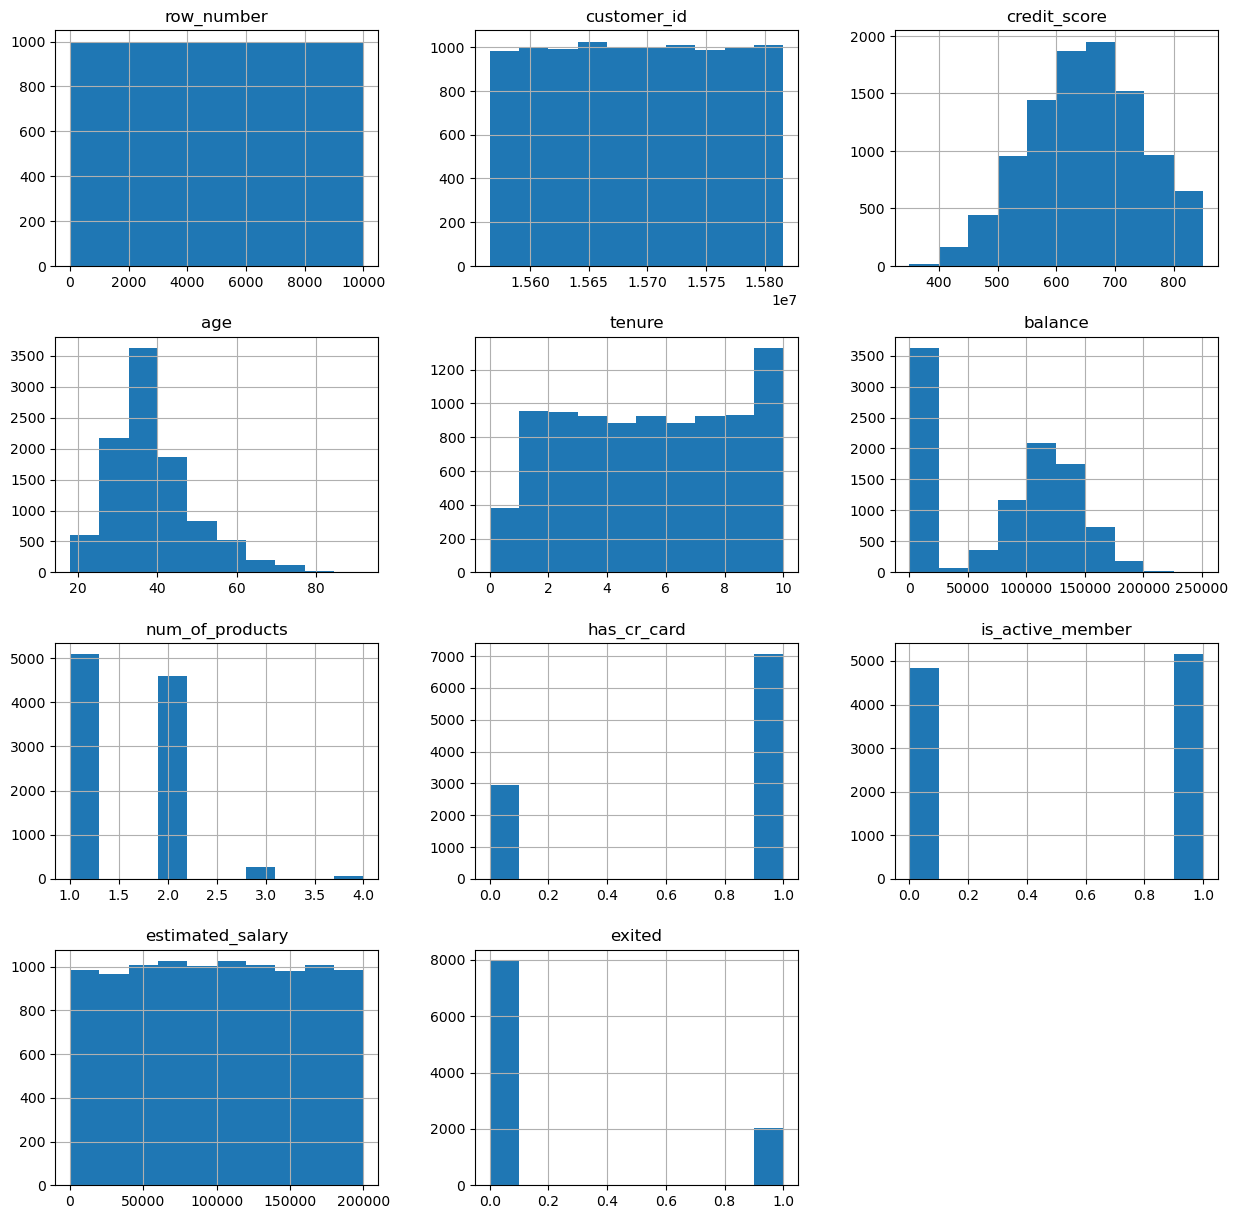

In [6]:
data.hist(figsize=(15, 15));

We will not consider the row_number and customer_id columns. For the rest we can say the following:

- the credit rating of most of the customers from the dataframe is estimated by banks at 600-700 points (whatever that means);
- the average age of customers is about 40 years old;
- data on the duration of the client's period of cooperation with the bank is presented in approximately equal shares from 0 to 10 years (slightly fewer clients in the 0 category, slightly more in the 10 category) - below we present a pie chart for clarity;
- the largest number of clients have zero account balance, if we exclude clients with zero balance, the average value will be about 120 ths;
- clients mostly use 1 or 2 products of the bank;
- in the dataset there are twice as many clients who have a credit card than those who do not;
- approximately equal proportions of customers who are and are not active members of the bank are represented in the dataset;
- consider the data on estimated wages in the mustache box plot;
- there are four times fewer customers in the dataset who have left the bank.

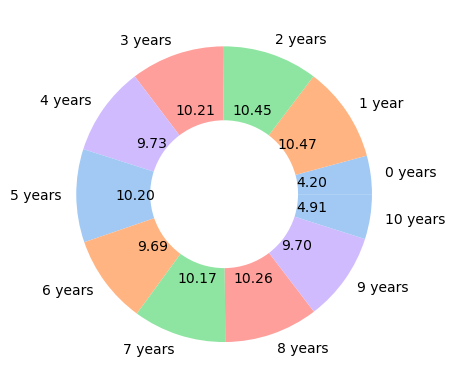

In [7]:
# chart on the data on the duration of the client's cooperation with the bank:

colors = sns.color_palette('pastel')[ 0:5 ]

labels = ["0 years", "1 year", "2 years", "3 years", "4 years", "5 years", "6 years" ,
          "7 years", "8 years", "9 years", "10 years"]
 
values = [len(data.loc[data['tenure']==0]), len(data.loc[data['tenure']==1]), len(data.loc[data['tenure']==2]),\
         len(data.loc[data['tenure']==3]), len(data.loc[data['tenure']==4]), len(data.loc[data['tenure']==5]),\
         len(data.loc[data['tenure']==6]), len(data.loc[data['tenure']==7]), len(data.loc[data['tenure']==8]),\
         len(data.loc[data['tenure']==9]),len(data.loc[data['tenure']==10])]


plt.pie(values, labels=labels, colors=colors, autopct='%.2f', wedgeprops=dict(width=0.5))
plt.show()

The pie chart confirmed the conclusion described above: the data on the duration of the customer's period of cooperation with the bank is presented in approximately equal proportions - approximately 10% for each category, except for the category 0 years - 4%, and 10 years - 5%.

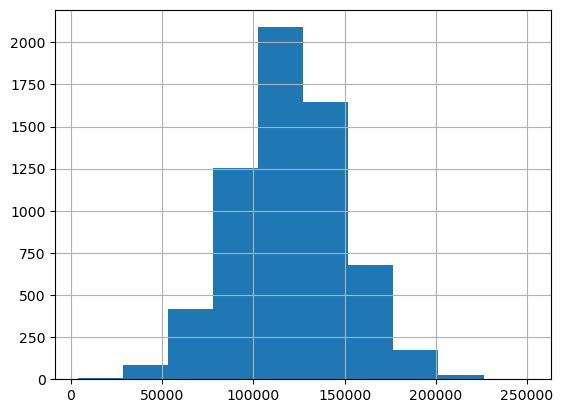

In [8]:
# let's look at the distribution of data on non-zero customer account balances:

data.loc[data['balance']>0]['balance'].hist();

Most of the clients in the set have 100-120k in their accounts.
Now let's look at the distribution of the data by the expected salary:

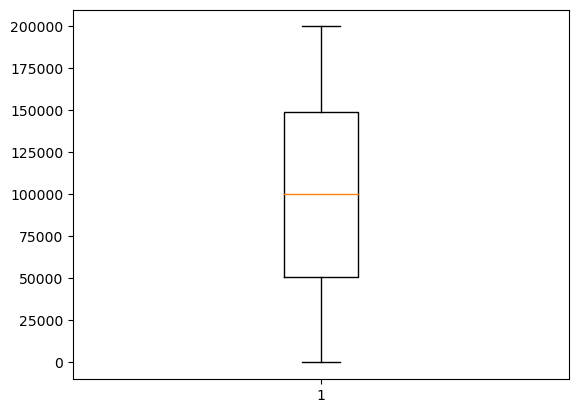

In [9]:
plt.boxplot(x=data['estimated_salary']);

In [10]:
data['estimated_salary'].describe()

count     10000.000000
mean     100090.239881
std       57510.492818
min          11.580000
25%       51002.110000
50%      100193.915000
75%      149388.247500
max      199992.480000
Name: estimated_salary, dtype: float64

Mostly, wages are estimated to be in the amount of 100 thousand.
Most of the data (1st and 3rd quartiles): 50 - 150 th.

There are missing values in the tenure column. It is necessary to find out whether this is a systematic error and how to deal with the omissions. Let's look at the data with missing values, check if there is a mutual influence of numeric columns:

In [11]:
data.query('tenure.isna() == True').corr()

,row_number,customer_id,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
row_number,1.000000,0.002624,0.038683,0.000455,NaN,-0.040211,-0.010692,-0.005296,0.036459,-0.018325,-0.036923
customer_id,0.002624,1.000000,0.069218,0.000028,NaN,-0.059415,0.039303,0.042422,0.003098,0.066181,0.001235
credit_score,0.038683,0.069218,1.000000,0.001027,NaN,0.039465,0.023283,-0.020099,-0.026097,-0.067141,-0.058002
age,0.000455,0.000028,0.001027,1.000000,NaN,-0.005604,-0.018039,0.014739,0.120013,-0.009525,0.310935
tenure,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
balance,-0.040211,-0.059415,0.039465,-0.005604,NaN,1.000000,-0.326853,0.026921,-0.077324,-0.002999,0.131570
num_of_products,-0.010692,0.039303,0.023283,-0.018039,NaN,-0.326853,1.000000,-0.022867,0.014828,0.016380,-0.023493
has_cr_card,-0.005296,0.042422,-0.020099,0.014739,NaN,0.026921,-0.022867,1.000000,-0.042472,-0.048790,-0.024521
is_active_member,0.036459,0.003098,-0.026097,0.120013,NaN,-0.077324,0.014828,-0.042472,1.000000,0.076619,-0.166911
estimated_salary,-0.018325,0.066181,-0.067141,-0.009525,NaN,-0.002999,0.016380,-0.048790,0.076619,1.000000,-0.028419


There is no significant correlation between the numerical data - therefore, there is no reason to consider the omissions as a systematic error. If we fill the gaps with the average value, we will get an imbalance, which may affect the result. It is not possible to find out with a high probability the value with which it is better to fill in the gaps, so we delete the missing values.

In [12]:
data = data.dropna(subset=['tenure']).reset_index(drop=True)

Check the data for obvious duplicates:

In [13]:
data.duplicated().sum()

0

In [14]:
data['customer_id'].value_counts().sum()

9091

No duplicates detected, data types correspond to the specified values. We can form a new data set, which will be used for model training. Declare the variable new_data, assign to it the values of data columns except for those that do not affect the model training ('row_number', 'customer_id', 'surname'):

In [15]:
new_data = data.drop(['row_number', 'customer_id', 'surname'], axis=1)
new_data.head()

,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
0,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


Let's use the pairplot method to see how the values of the target attribute are distributed:

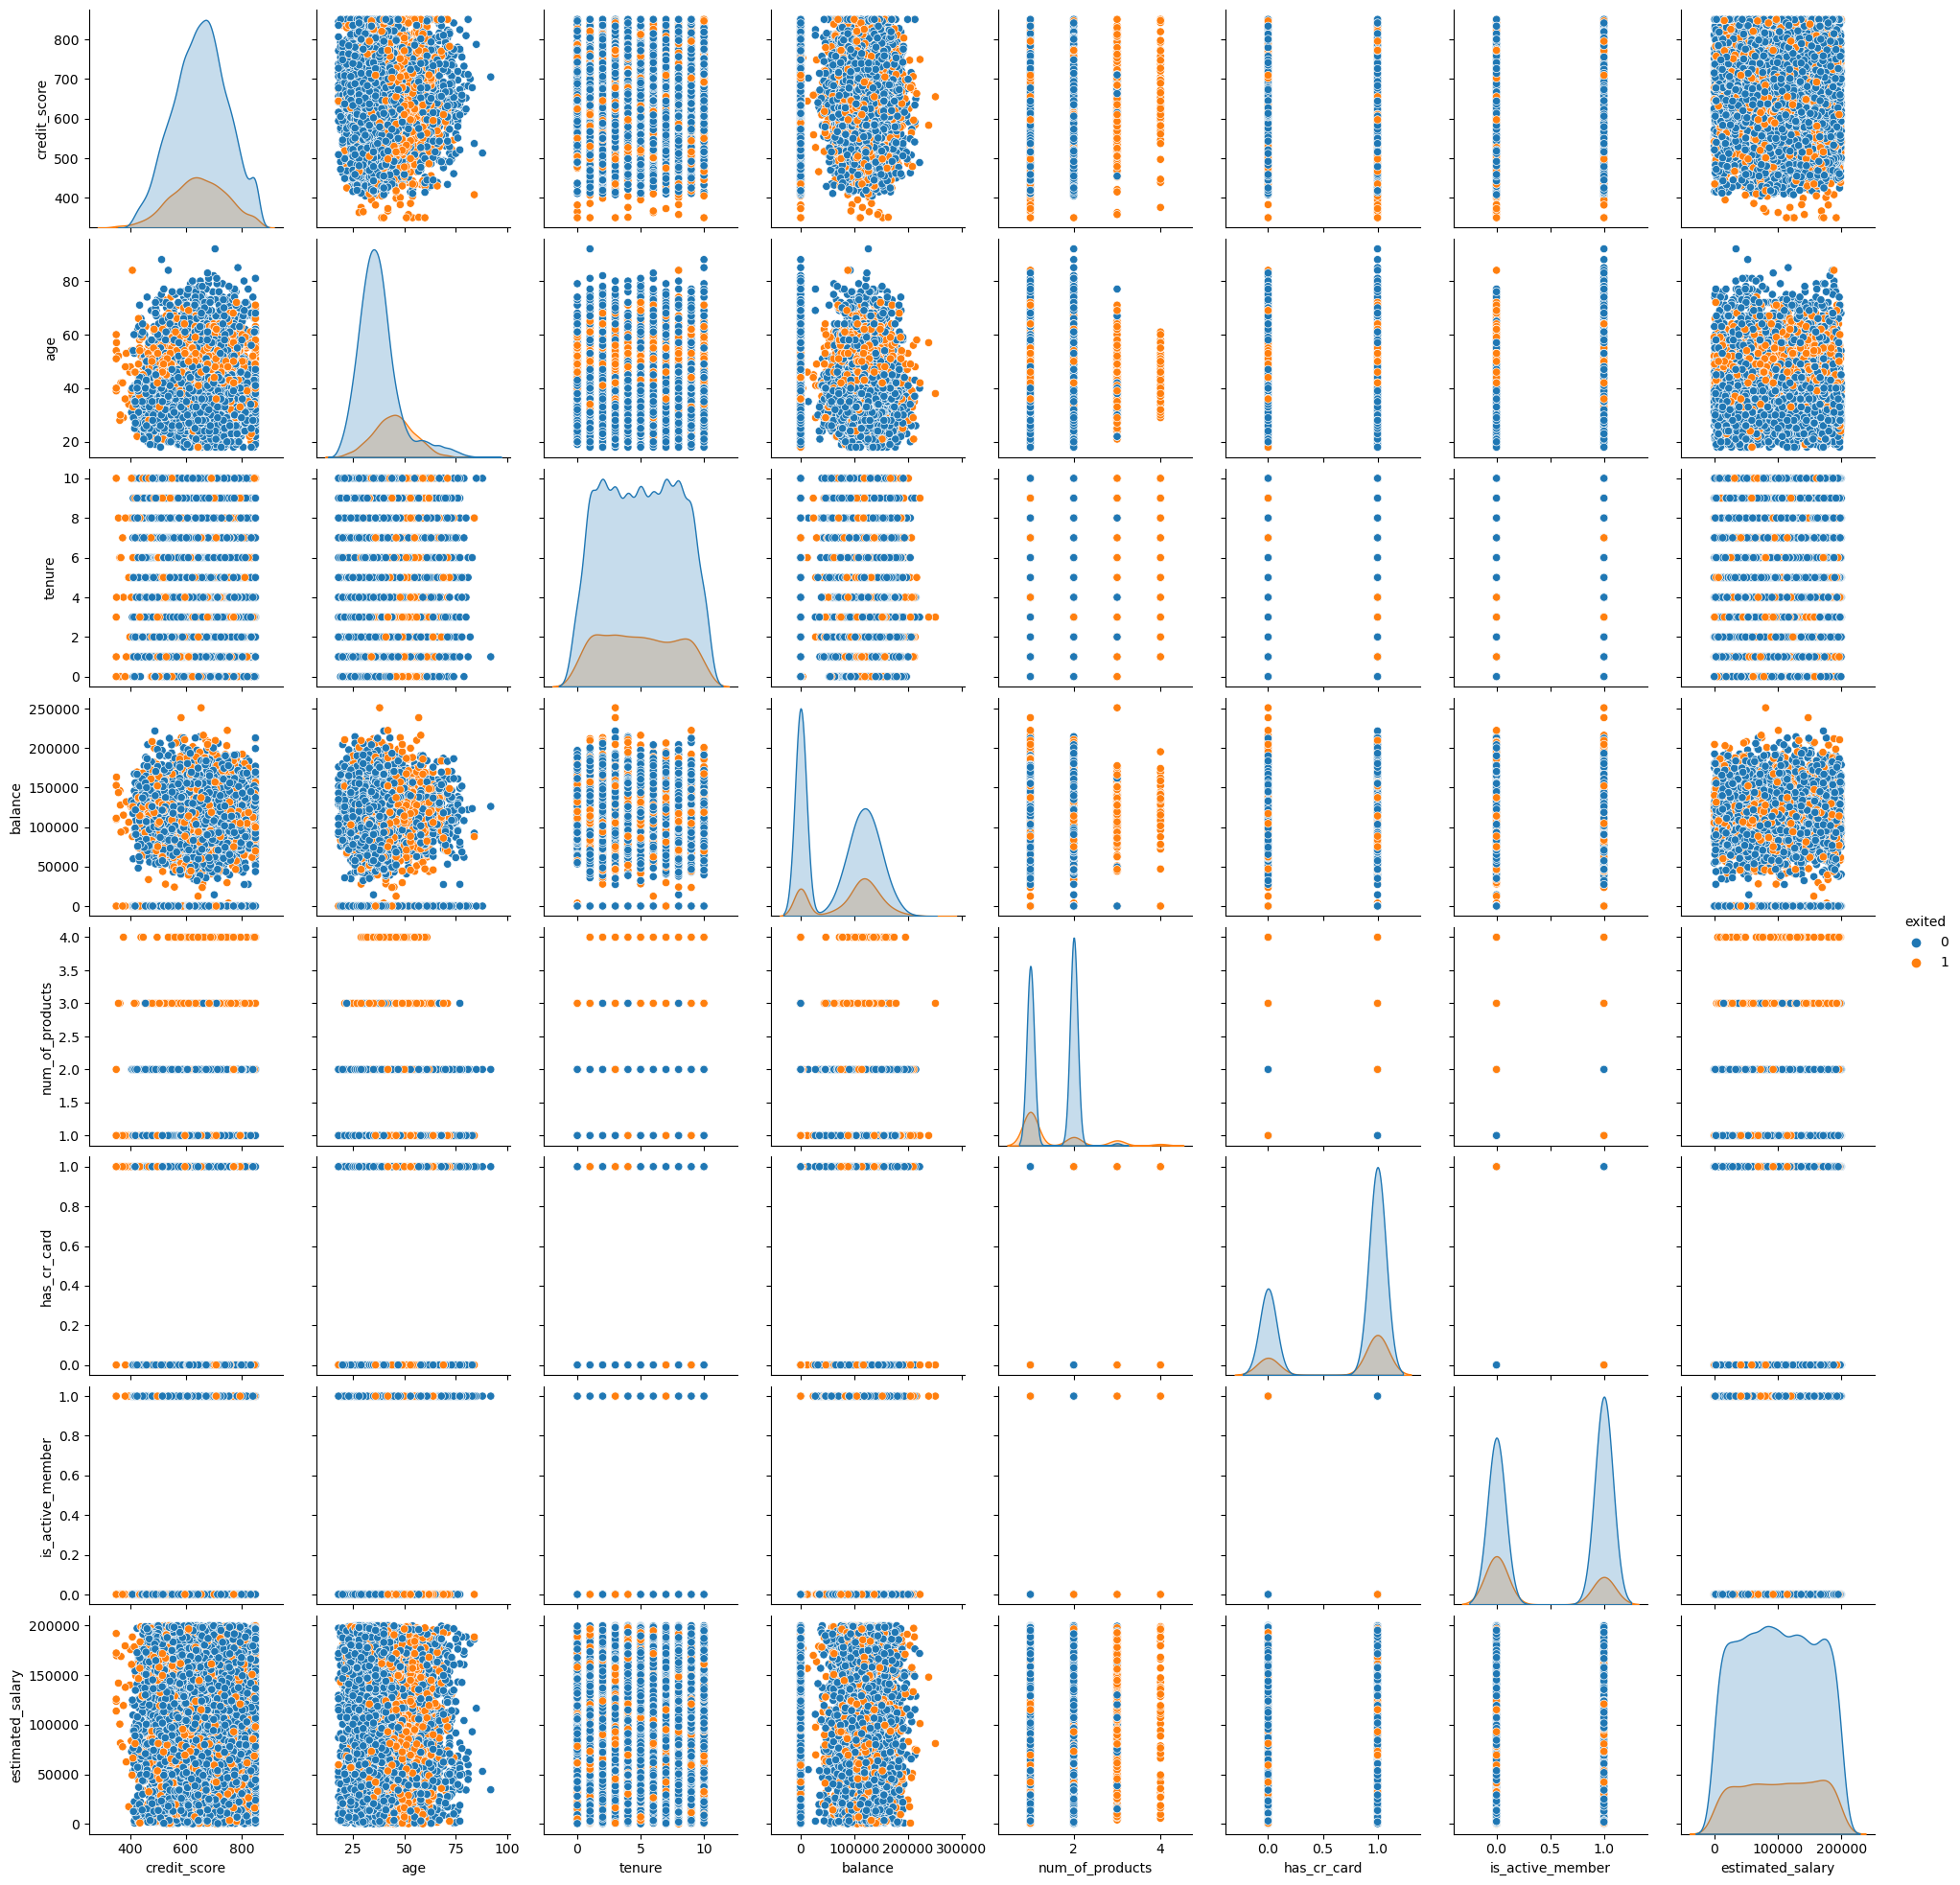

In [16]:
sns.pairplot(new_data, hue="exited");

After outputting the graph, we can clearly see that on average, customers who left the bank have:

- credit rating is twice as high (800 and 400 respectively);
- the balance is about 100 thousand, the balance of those who left the bank is about 50 thousand;
- the number of products used by the bank is higher;
- the expected salary is higher.

The impression is that the most profitable clients left the bank.

Convert the gender, geography columns from categorical to numerical by ohe:

In [17]:
new_data = pd.get_dummies(new_data, drop_first=True)
new_data.head()

,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited,geography_Germany,geography_Spain,gender_Male
0,619,42,2.0,0.00,1,1,1,101348.88,1,0,0,0
1,608,41,1.0,83807.86,1,0,1,112542.58,0,0,1,0
2,502,42,8.0,159660.80,3,1,0,113931.57,1,0,0,0
3,699,39,1.0,0.00,2,0,0,93826.63,0,0,0,0
4,850,43,2.0,125510.82,1,1,1,79084.10,0,0,1,0


In [18]:
new_data.columns = ['credit_score', 'age', 'tenure', 'balance', 'num_of_products', 'has_cr_card',
       'is_active_member', 'estimated_salary', 'exited', 'geography_germany', 'geography_spain',
       'gender_male']

The new dataframe is ready. Let's move on to the formation of samples. Taking into account the fact that only the original dataset is available to us, let's divide the data according to the scenario 3:1:1 (60% of the data will be left for the training sample, 20% for the test sample and 20% for the validation sample).

In [19]:
new_data_train, new_data_test = train_test_split(new_data, test_size=0.4, random_state=12345)
new_data_test, new_data_valid = train_test_split(new_data_test, test_size=0.5, random_state=12345) 

Now create variables for features and target for all samples. We will use the 'exited' column as the target:

In [20]:
# variables for the training sample:

features_train = new_data_train.drop(['exited'], axis=1)
target_train = new_data_train['exited']

# variables for the test sample:

features_test = new_data_test.drop(['exited'], axis=1)
target_test = new_data_test['exited']

# variables for validation sampling:

features_valid = new_data_valid.drop(['exited'], axis=1)
target_valid = new_data_valid['exited']

In [21]:
print(features_train.shape)
print(target_train.shape)
print(features_test.shape)
print(target_test.shape)
print(features_valid.shape)
print(target_valid.shape)

(5454, 11)
(5454,)
(1818, 11)
(1818,)
(1819, 11)
(1819,)


Thus, we got samples of 6000 items for training, 2000 items for testing and 2000 for vadidation. Let's move on to finding the best model.

## Exploring the task

Train three models: decision tree, random forest and logistic regression.

Let's test the accuracy of the models:

In [22]:
def all_models_accuracy(features_train, target_train, features_valid, target_valid):
    
    # decision tree:
    dtc = DecisionTreeClassifier(random_state=12345)
    dtc_ac_score = dtc.fit(features_train, target_train).score(features_valid, target_valid)
    
    # random forest:
    rfc = RandomForestClassifier(n_estimators = 500, random_state=12345)
    rfc_ac_score = rfc.fit(features_train, target_train).score(features_valid, target_valid)
    
    # logistic regression:
    lg = LogisticRegression(solver = 'liblinear', random_state=12345)
    lg_ac_score = lg.fit(features_train, target_train).score(features_valid, target_valid)
    
    print("Accuracy models:")
    print()
    print("'decision tree': ", dtc_ac_score)
    print("'random forest': ", rfc_ac_score)
    print("'logistic regression': ", lg_ac_score)
    
all_models_accuracy(features_train, target_train, features_valid, target_valid)

Accuracy models:

'decision tree':  0.7982407916437603
'random forest':  0.8647608576140736
'logistic regression':  0.8053875755909841


The random forest model proved to be the most accurate.

Let's compare the accuracy of the predictions with those of the constant model. The first step is to determine what answer the constant model will "predict", for this purpose we check the fractions 1 and 0 in the exited column:

In [23]:
# determine share of 1:

sum(new_data['exited']/len(new_data))

0.2039379606204001

There is a noticeable imbalance in the data. Only about 20% of the exited column values are equal to 1. Therefore, it makes sense to create a constant model that will "predict" zero values:

In [24]:
# create a constant model:

target_predict_constant = pd.Series([0]*len(target_valid))

# check the prediction accuracy of the constant model:

accuracy_score_constant = accuracy_score(target_valid, target_predict_constant)
accuracy_score_constant

0.8070368334249588

The Accuracy of the constant model is higher than that of the decision tree and logistic regression.

Let us construct the error matrices:

In [25]:
# decision tree confusion matrix:

dtc = DecisionTreeClassifier(random_state=12345)
dtc.fit(features_train, target_train)
dtc_prediction = dtc.predict(features_valid)

confusion_matrix(target_valid, dtc_prediction)

array([[1276,  192],
       [ 175,  176]], dtype=int64)

The decision tree predictions yield approximately the same number of false-positive and false-negative responses. However, given the imbalance in the data, we conclude that the model tends to produce false-positive predictions.

In [26]:
#confusion matrix for a random forest:

rfc = RandomForestClassifier(random_state=12345, n_estimators = 500)
rfc.fit(features_train, target_train)
rfc_prediction = rfc.predict(features_valid)

confusion_matrix(target_valid, rfc_prediction)

array([[1417,   51],
       [ 195,  156]], dtype=int64)

The random forest model is just as prone to false-positive predictions as the decision tree model.

In [27]:
#confusion matrix for logistic regression:

lg = LogisticRegression(random_state=12345, solver = 'liblinear')
lg.fit(features_train, target_train)
lg_prediction = lg.predict(features_valid)

confusion_matrix(target_valid, lg_prediction)

array([[1450,   18],
       [ 336,   15]], dtype=int64)

The conclusion is similar.

Let's check the accuracy of the models:

In [28]:
def recall_precision_f1(target_valid, prediction):
    print("Recall" , recall_score(target_valid, prediction))
    print("Precision" , precision_score(target_valid, prediction))
    print("F1-measure", f1_score(target_valid, prediction))
    
#recall, precision and F1-measure for the decision tree

print("'decision tree:'")
print()

recall_precision_f1(target_valid, dtc_prediction)

'decision tree:'

Recall 0.5014245014245015
Precision 0.4782608695652174
F1-measure 0.48956884561891517


In [29]:
#recall, precision and F1-measure for the random forest

print("'random forest:'")
print()
recall_precision_f1(target_valid, rfc_prediction)

'random forest:'

Recall 0.4444444444444444
Precision 0.7536231884057971
F1-measure 0.5591397849462365


In [30]:
#recall, precision and F1-measure for the logistic regression

print("'logistic regression:'")
print()
recall_precision_f1(target_valid, lg_prediction)

'logistic regression:'

Recall 0.042735042735042736
Precision 0.45454545454545453
F1-measure 0.078125


The F-1 of the random forest is the highest. However, the values of the metrics are far from ideal.

Let us check the adequacy:

In [31]:
def all_models_share(features_train, target_train, features_valid, target_valid):
    dtc = DecisionTreeClassifier(random_state=12345)
    dtc.fit(features_train, target_train)
    dtc_share = pd.Series(dtc.predict(features_valid)).value_counts(normalize = 1)
    
    rfc = RandomForestClassifier(random_state=12345, n_estimators = 500)
    rfc.fit(features_train, target_train)
    rfc_share = pd.Series(rfc.predict(features_valid)).value_counts(normalize = 1)
    
    lg = LogisticRegression(random_state=12345, solver = 'liblinear')
    lg.fit(features_train, target_train)
    lg_share = pd.Series(lg.predict(features_valid)).value_counts(normalize = 1)
    
    print ("Fraction of responses:")
    print()
    print ("'decision tree':")
    print (dtc_share)
    print()
    print ("'random forest':")
    print (rfc_share)
    print()
    print ("'logistic regression':")
    print (lg_share)
    
all_models_share(features_train, target_train, features_valid, target_valid)    

Fraction of responses:

'decision tree':
0    0.797691
1    0.202309
dtype: float64

'random forest':
0    0.886201
1    0.113799
dtype: float64

'logistic regression':
0    0.981858
1    0.018142
dtype: float64


Almost all predictions (97%) of logistic regression are 0. Its accuracy is comparable to that of the constant model. Predictions of other models are also mostly equal to 0. This is primarily due to unbalanced data. It is necessary to eliminate it.

## Unbalance exception

We found out earlier that about 20% of the values in the target feature are 1. Therefore, the ratio of units to zeros is 0.25 to 1. So we need to increase the number of units or reduce the number of zeros by a factor of four. Let's start with increasing the number of units:

In [32]:
# increase the number of values equal to 1:

def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

features_upsampled_train, target_upsampled_train = upsample(features_train, target_train, repeat=4)

In [33]:
print(target_upsampled_train.value_counts(normalize = 1))
print(target_upsampled_train.shape)

1    0.509964
0    0.490036
Name: exited, dtype: float64
(8832,)


We obtained a balanced training sample. Let's check whether the metrics have changed:

In [34]:
# Accuracy of models on unbalanced data:

print ('Unbalanced data')
print ()
all_models_accuracy(features_train, target_train, features_valid, target_valid)

# Accuracy of models after upsample method:

print ()
print ('Balanced data')
print ()
all_models_accuracy(features_upsampled_train, target_upsampled_train, \
                    features_valid, target_valid)

Unbalanced data

Accuracy models:

'decision tree':  0.7982407916437603
'random forest':  0.8647608576140736
'logistic regression':  0.8053875755909841

Balanced data

Accuracy models:

'decision tree':  0.7877954920285871
'random forest':  0.8592633315008247
'logistic regression':  0.6470588235294118


The accuracy value for all models decreased. Let's check accuracy, completeness and F-1:

In [35]:
# decision tree:

dtc_upsampled = DecisionTreeClassifier(random_state=12345)
dtc_upsampled.fit(features_upsampled_train, target_upsampled_train)
dtc_prediction_upsampled = dtc_upsampled.predict(features_valid)

print("Metrics for decision tree on unbalanced data:")
print()
recall_precision_f1(target_valid, dtc_prediction)

print()
print("Metrics for decision tree on balanced data:")
print()
recall_precision_f1(target_valid, dtc_prediction_upsampled)

Metrics for decision tree on unbalanced data:

Recall 0.5014245014245015
Precision 0.4782608695652174
F1-measure 0.48956884561891517

Metrics for decision tree on balanced data:

Recall 0.48717948717948717
Precision 0.4535809018567639
F1-measure 0.4697802197802198


In [36]:
# random forest:

rfc_upsampled = RandomForestClassifier(random_state=12345, n_estimators = 500)
rfc_upsampled.fit(features_upsampled_train, target_upsampled_train)
rfc_prediction_upsampled = rfc_upsampled.predict(features_valid)

print("Metrics for random forest on unbalanced data:")
print()
recall_precision_f1(target_valid, rfc_prediction)

print()
print("Metrics for random forest on balanced data:")
print()
recall_precision_f1(target_valid, rfc_prediction_upsampled)

Metrics for random forest on unbalanced data:

Recall 0.4444444444444444
Precision 0.7536231884057971
F1-measure 0.5591397849462365

Metrics for random forest on balanced data:

Recall 0.5555555555555556
Precision 0.6610169491525424
F1-measure 0.6037151702786377


In [37]:
# logistic regression:

lg_upsampled = LogisticRegression(random_state=12345, solver = 'liblinear')
lg_upsampled.fit(features_upsampled_train, target_upsampled_train)
lg_prediction_upsampled = lg_upsampled.predict(features_valid)

print("Metrics for logistic regression on unbalanced data:")
print()
recall_precision_f1(target_valid, lg_prediction)

print()
print("Metrics for logistic regression on balanced data:")
print()
recall_precision_f1(target_valid, lg_prediction_upsampled)


Metrics for logistic regression on unbalanced data:

Recall 0.042735042735042736
Precision 0.45454545454545453
F1-measure 0.078125

Metrics for logistic regression on balanced data:

Recall 0.6809116809116809
Precision 0.3107932379713914
F1-measure 0.42678571428571427


Some values of the models' metrics improved. The random forest model showed the most accurate predictions. The F-1 value on the validation sample after applying the upsample method is 0.61 (higher than the target 0.59). However, the prediction quality still leaves much to be desired. Let's try the downsample method:

In [38]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)
    
    return features_downsampled, target_downsampled

features_downsampled_train, target_downsampled_train = downsample(features_train, target_train, fraction=0.25)

In [39]:
print(target_downsampled_train.value_counts(normalize = 1))
print(target_downsampled_train.shape)

1    0.509964
0    0.490036
Name: exited, dtype: float64
(2208,)


In [40]:
# Accuracy of models on unbalanced data:

print ('Unbalanced data')
print ()
all_models_accuracy(features_train, target_train, features_valid, target_valid)

# Accuracy of models after downsample method:

print ()
print ('Balanced data')
print ()
all_models_accuracy(features_downsampled_train, target_downsampled_train, \
                    features_valid, target_valid)

Unbalanced data

Accuracy models:

'decision tree':  0.7982407916437603
'random forest':  0.8647608576140736
'logistic regression':  0.8053875755909841

Balanced data

Accuracy models:

'decision tree':  0.7130291368884002
'random forest':  0.7564595931830677
'logistic regression':  0.6465090709180868


In [41]:
# decision tree:

dtc_downsampled = DecisionTreeClassifier(random_state=12345)
dtc_downsampled.fit(features_downsampled_train, target_downsampled_train)
dtc_prediction_downsampled = dtc_downsampled.predict(features_valid)

print("Metrics for decision tree on unbalanced data:")
print()
recall_precision_f1(target_valid, dtc_prediction)

print()
print("Metrics for decision tree on balanced data:")
print()
recall_precision_f1(target_valid, dtc_prediction_downsampled)

Metrics for decision tree on unbalanced data:

Recall 0.5014245014245015
Precision 0.4782608695652174
F1-measure 0.48956884561891517

Metrics for decision tree on balanced data:

Recall 0.7606837606837606
Precision 0.37872340425531914
F1-measure 0.5056818181818181


In [42]:
# random forest:

rfc_downsampled = RandomForestClassifier(random_state=12345, n_estimators = 500)
rfc_downsampled.fit(features_downsampled_train, target_downsampled_train)
rfc_prediction_downsampled = rfc_downsampled.predict(features_valid)

print("Metrics for random forest on unbalanced data:")
print()
recall_precision_f1(target_valid, rfc_prediction)

print()
print("Metrics for random forest on balanced data:")
print()
recall_precision_f1(target_valid, rfc_prediction_downsampled)

Metrics for random forest on unbalanced data:

Recall 0.4444444444444444
Precision 0.7536231884057971
F1-measure 0.5591397849462365

Metrics for random forest on balanced data:

Recall 0.7749287749287749
Precision 0.4276729559748428
F1-measure 0.5511651469098278


In [43]:
# logistic regression:

lg_downsampled = LogisticRegression(random_state=12345, solver = 'liblinear')
lg_downsampled.fit(features_downsampled_train, target_downsampled_train)
lg_prediction_downsampled = lg_downsampled.predict(features_valid)

print("Metrics for logistic regression on unbalanced data:")
print()
recall_precision_f1(target_valid, lg_prediction)

print()
print("Metrics for logistic regression on balanced data:")
print()
recall_precision_f1(target_valid, lg_prediction_downsampled)

Metrics for logistic regression on unbalanced data:

Recall 0.042735042735042736
Precision 0.45454545454545453
F1-measure 0.078125

Metrics for logistic regression on balanced data:

Recall 0.6951566951566952
Precision 0.3128205128205128
F1-measure 0.43147656940760387


In terms of aggregate performance, the random forest model shows the best predictions among the other models. Let us try to find the most efficient number of trees (maximize f1):

In [44]:
# for upsampled: 

best_model = None
best_result = 0

for est in range(100, 700, 50):
    
    # create a model with the given number of trees:
    model = RandomForestClassifier(random_state=12345, n_estimators=est) 
    
    # train it on the training sample
    model.fit(features_upsampled_train, target_upsampled_train) 
    
    # make predictions on the validation sample data:
    predictions_valid = model.predict(features_valid)
    
    # check the model's f1 on the validation sample data:
    f1_valid = f1_score(target_valid, predictions_valid) 
    
    if f1_valid > best_result:
        
        # keep the best model
        best_model = model
        
        # keep the best accuracy metric
        best_result = f1_valid
        
        # save the best value for the number of trees
        best_est = est

print("f1 best model on training sample:", best_result, ", n_estimators best model:", best_est)

f1 best model on training sample: 0.6120556414219475 , n_estimators best model: 100


In [45]:
# for downsampled: 

best_model = None
best_result = 0

for est in range(100, 700, 50):
    
    # create a model with the given number of trees:
    model = RandomForestClassifier(random_state=12345, n_estimators=est) 
    
    # train it on the training sample
    model.fit(features_downsampled_train, target_downsampled_train) 
    
    # make predictions on the validation sample data:
    predictions_valid = model.predict(features_valid)
    
    # check the model's f1 on the validation sample data:
    f1_valid = f1_score(target_valid, predictions_valid) 
    
    if f1_valid > best_result:
        
        # keep the best model
        best_model = model
        
        # save the best accuracy metric
        best_result = f1_valid
        
        # save the best value for the number of trees
        best_est = est

print("f1 best model on training sample:", best_result, ", n_estimators best model:", best_est)

f1 best model on training sample: 0.5627530364372471 , n_estimators best model: 100


A random forest model trained on an upsampled data with 100 trees is sent for final testing.

## Testing the model

In [46]:
rfc_upsampled = RandomForestClassifier(random_state=12345, n_estimators = 100)
rfc_upsampled.fit(features_upsampled_train, target_upsampled_train)
final_rfc_prediction = rfc_upsampled.predict(features_test)

print("Accuracy:", accuracy_score(final_rfc_prediction, target_test))
recall_precision_f1(target_test, final_rfc_prediction)
print("AUC-ROC:", roc_auc_score(target_test, final_rfc_prediction))

Accuracy: 0.8536853685368537
Recall 0.5490716180371353
Precision 0.6831683168316832
F1-measure 0.6088235294117647
AUC-ROC: 0.7412256077694351


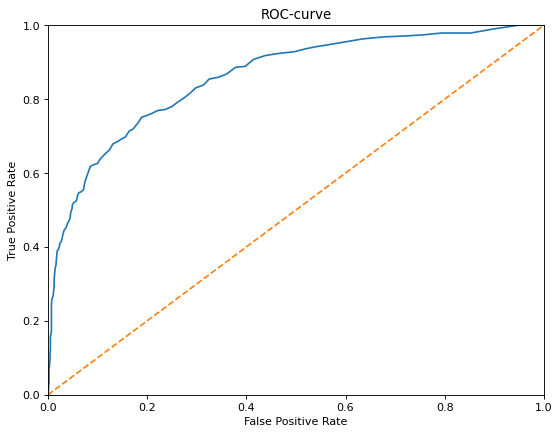

In [47]:
rfc_upsampled_probabilities_one = rfc_upsampled.predict_proba(features_test)[:, 1]

fpr, tpr, thresholds = roc_curve(target_test, rfc_upsampled_probabilities_one) 

plt.figure(figsize=(8, 6), dpi=80)
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-curve')
plt.show()

The AUC-ROC value is higher than the F1 value. The obtained model gives better predictions than the constant model.  The F1 threshold is passed, but the values of other metrics remain quite low. 

In about half of cases (completeness 0.55) the model will predict the customer leaving the bank and in 85% of cases the prediction will be correct (accuracy 0.85). 

To improve the quality of the model, we can try to build predictions for different clusters (e.g., divide the data by countries) or try to consider the data in dynamics, provided that the bank has relevant information.